In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

Creating the input

In [2]:
expect_img_size = 128 
input = tf.keras.Input([None, None, 3])
resize = tf.keras.layers.experimental.preprocessing.Resizing(expect_img_size, expect_img_size, interpolation='bilinear', name="input")(input)
effNet = tf.keras.applications.EfficientNetB3(include_top=False, input_shape=[expect_img_size, expect_img_size, 3])

Extracting layers which should be upscaled

In [3]:
skip_conns = []
shapes = {}
for layer in effNet.layers:
    key = str(layer.output_shape[1:-1])
    if type(layer) != tf.keras.layers.Activation:
        continue
    if key not in shapes:
        shapes[key] = None
    shapes[key] = layer

for _, layer in shapes.items():
    skip_conns.append(layer.output)

skip_conns = skip_conns[::-1]
    
down_stack = tf.keras.Model(inputs=effNet.input, outputs=skip_conns)
down_stack.trainable = False

Creating the UNet-Model

In [4]:
def upscale(in_tensor, out_shape, out_channels, activation="relu"):
    if in_tensor.shape[1]*2 < out_shape[1]:
        in_tensor = tf.keras.layers.ZeroPadding2D()(in_tensor)
    result = tf.keras.layers.Conv2DTranspose(out_channels, 3, strides=2, padding='same', use_bias=False)(in_tensor)
    result = tf.keras.layers.BatchNormalization()(result)
    if activation == "relu":
        result = tf.keras.layers.ReLU()(result)
    if activation == "leaky_relu":
        result = tf.keras.layers.LeakyReLU()(result)
    elif activation == "softmax":
        result = tf.keras.layers.Softmax()(result)
    elif activation == "sigmoid":
        result = tf.keras.activations.sigmoid(result)
    return result

skip_conns = down_stack(resize)
out = skip_conns[0]
for i in range(1,len(skip_conns)):
    result = upscale(out, skip_conns[i].shape, skip_conns[i].shape[-1], "relu")
    out = tf.keras.layers.Concatenate()([result, skip_conns[i]])
out = upscale(out, resize.shape, 3, "softmax")
model = tf.keras.Model(input, out)

Printing the UNet-Model

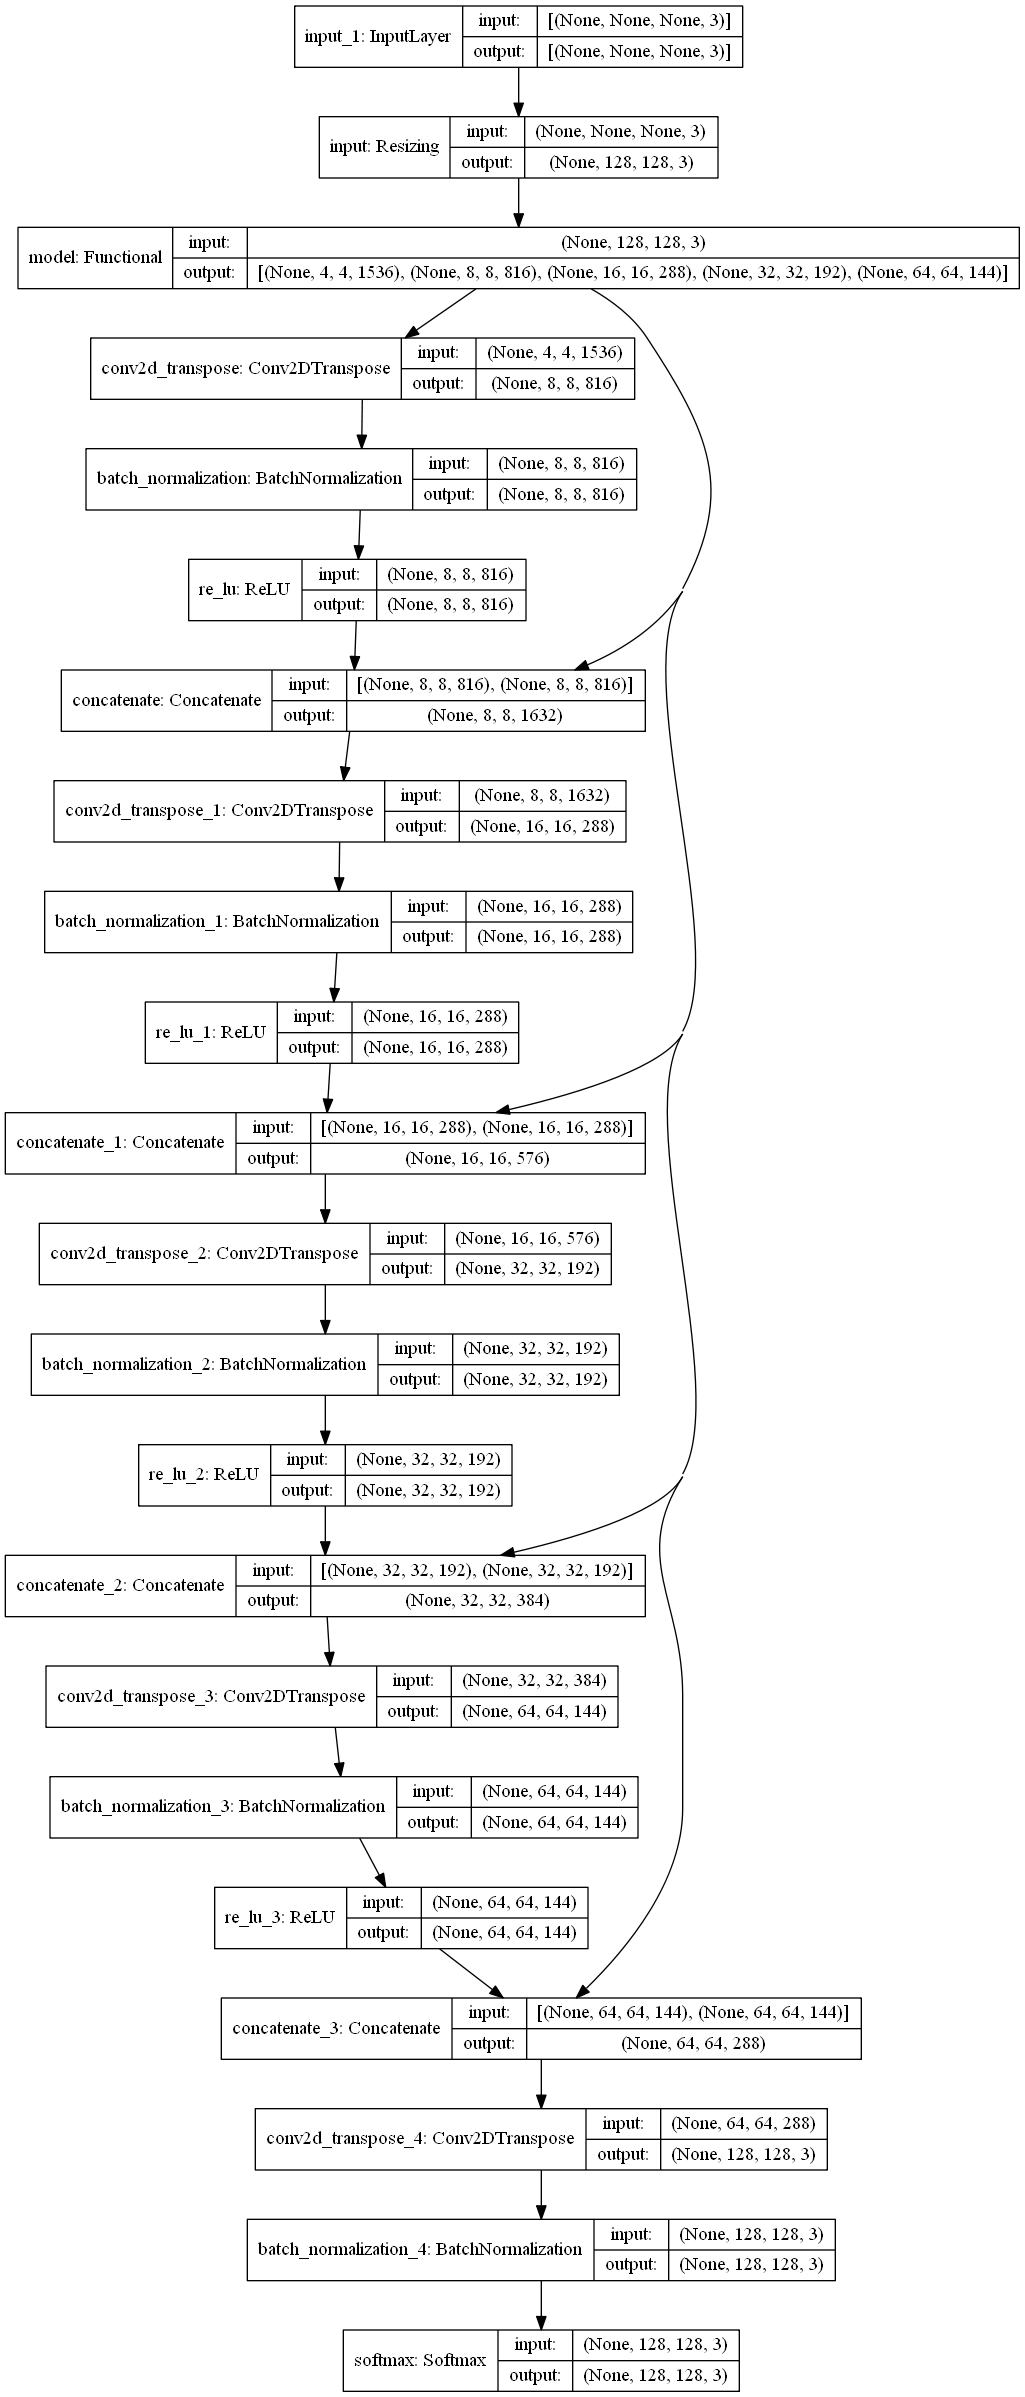

In [5]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [6]:
import numpy as np
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in effNet.trainable_weights])
print("EfficienNet\n", trainable_count)
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("UNet\n", trainable_count)

EfficienNet
 0.0
UNet
 17014182


In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

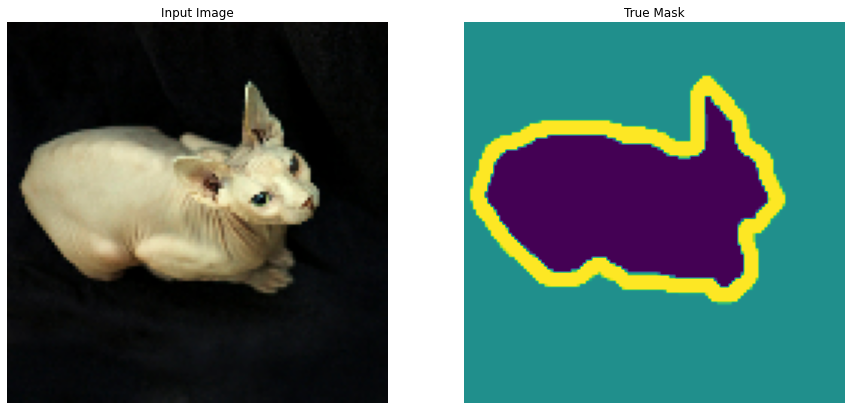

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
checkpoint_filepath = 'tmp/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

display_callback = DisplayCallback()

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)

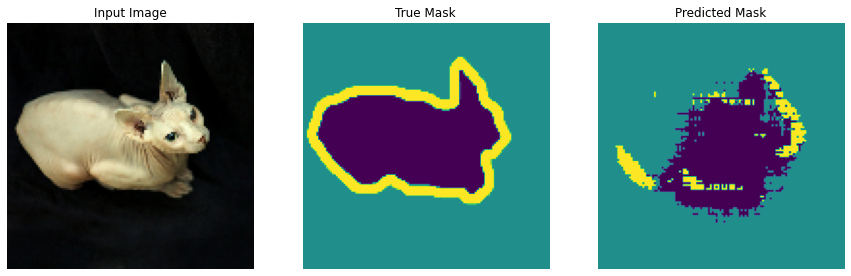


Sample Prediction after epoch 50



In [15]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[display_callback, checkpoint_callback])

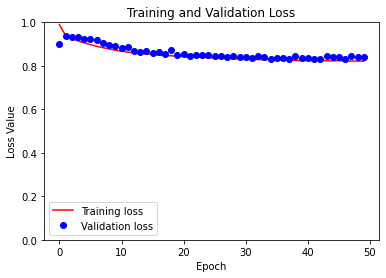

In [16]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

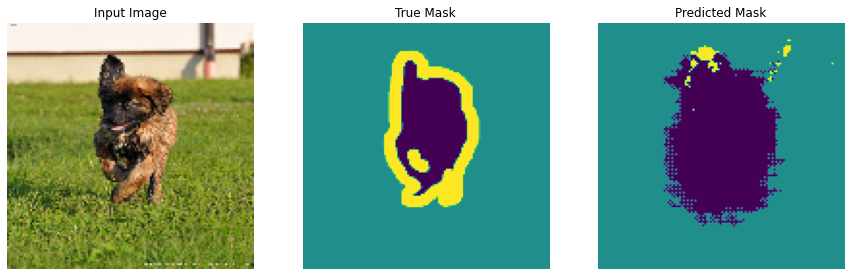

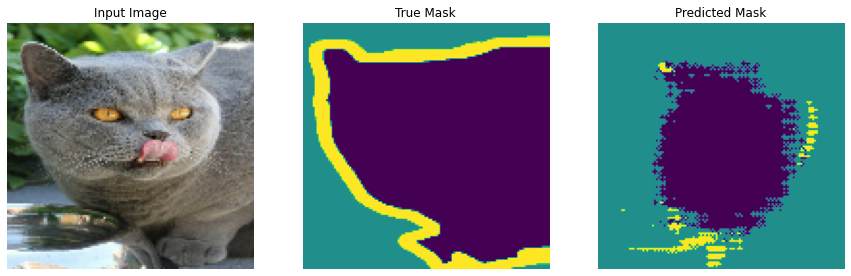

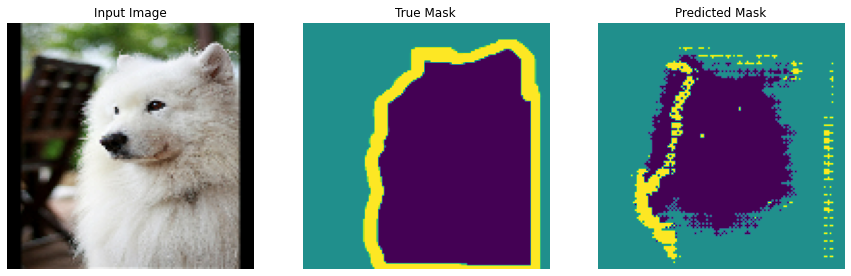

In [17]:
model.load_weights(checkpoint_filepath + "/variables/variables")
show_predictions(test_dataset, 3)

In [18]:
model.trainable = True

trainable_count = np.sum([tf.keras.backend.count_params(w) for w in effNet.trainable_weights])
print("EfficienNet\n", trainable_count)
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print("UNet\n", trainable_count)

EfficienNet
 10696232
UNet
 27710414


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

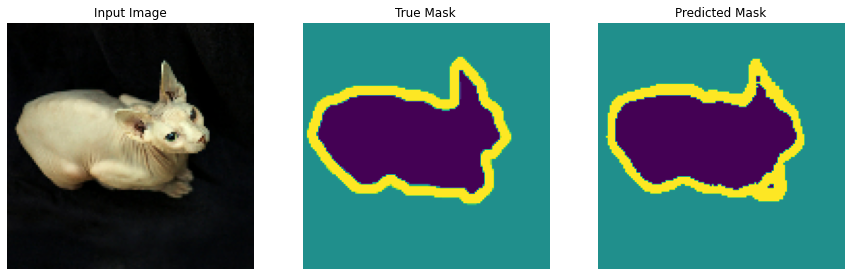


Sample Prediction after epoch 50



In [20]:
EPOCHS = 50
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[display_callback, checkpoint_callback])

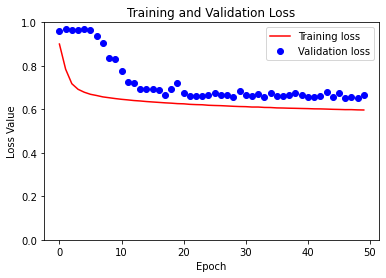

In [21]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

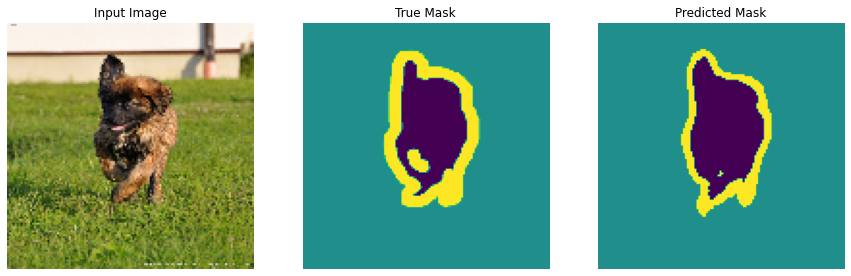

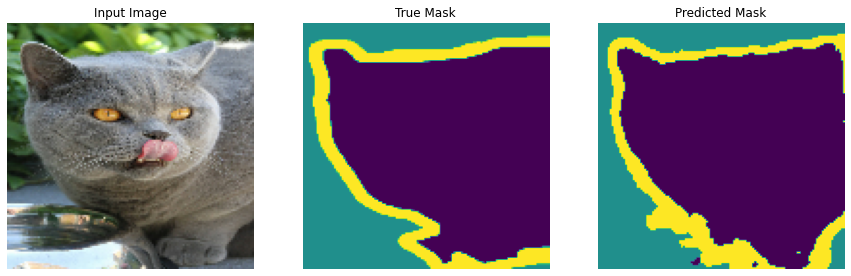

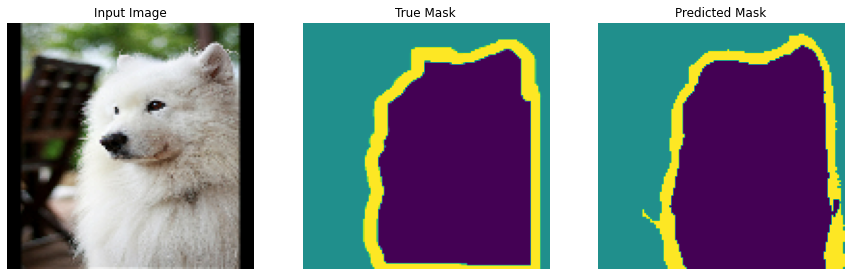

In [22]:
model.load_weights(checkpoint_filepath + "/variables/variables")
show_predictions(test_dataset, 3)